# Implement SVR model

In [2]:
import warnings
warnings.filterwarnings('ignore')

from time import time
from datetime import timedelta

import pandas as pd
import seaborn as sns
import numpy as np


from scipy.stats import chi2_contingency 
from scipy.stats import pearsonr 

from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale

from sklearn.svm import LinearSVR, SVR, SVC
from sklearn.neighbors import KNeighborsRegressor

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from dython.nominal import associations
from dython.nominal import correlation_ratio
from dython.nominal import cramers_v

from matplotlib import pyplot as plt

from get_metrics import write_metrics_in_csv

RUN TWICE THE PREVIOUS CELL

In [3]:
# Open dataset
filename: str = 'dataset.csv'
dataset = pd.read_pickle('dataRead_processed.pkl.bz2', compression='bz2')

# Split dataset
X = dataset.drop(columns=['total_passengers_2022'])
y = dataset['total_passengers_2022']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
dataset.drop(columns=['total_passengers_and_non_passengers_2022', 'total_passengers_and_non_passengers_2015', 'total_passengers_2015'], inplace=True)

In [5]:
def minimum_preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    # We kill categorical columns
    X = X.drop(columns=X.select_dtypes(include='object').columns)
    X = X.drop(columns=X.select_dtypes(include='category').columns)
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    # Normalize
    
    print(X.dtypes)
    # X = minmax_scale(X)
    # print('New shape:{}'.format(X.shape))
    return X, y

X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Original shape:(1491, 38)
total_passengers_and_non_passengers_2022            float64
total_passengers_2015                               float64
total_passengers_and_non_passengers_2015            float64
wifi_service                                          int64
city_category_in_attraction_area_2020                 int64
department                                            int64
region                                                int64
sum_municipal_population_2021                         int64
non_scholarized_15_years_old_or_more_2020             int64
main_residences_2020                                  int64
housing_2020                                          int64
jobs_at_workplace_2020                                int64
hotels_2024_sum                                       int64
camping_sites_2024_sum                                int64
other_tourist_accommodations_2024_sum                 int64
latitude                                            float64
longitude     

<Axes: xlabel='total_passengers_2022'>

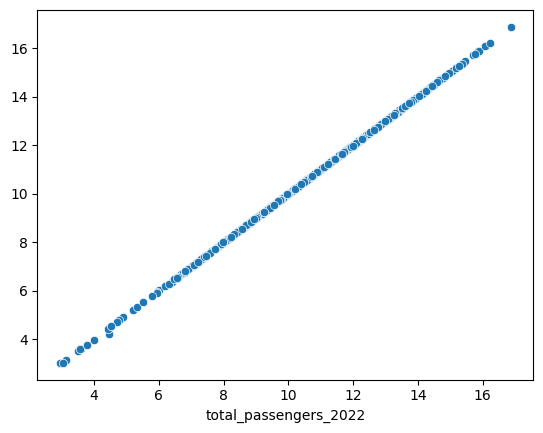

In [6]:
svm = LinearSVR()

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

model = 'SVR'
hyperparameters = {'type': 'linear', 'C': 1, 'epsilon': 0}

write_metrics_in_csv(y_test, y_pred, model, hyperparameters)

# sns.scatterplot(x=y_test, y=y_pred)
sns.scatterplot(x=np.log(y_test), y=np.log(y_pred))

In [7]:
Cs = [0.1, 1, 10, 100, 1000]
epsilons = [0, 0.1, 0.01, 0.001]

model = 'SVR'
kernel = 'linear'

for c in Cs:
    print(f'c: {c}')
    for epsilon in epsilons:
        print(f'\tepsilon: {epsilon}')
        svm = LinearSVR(C=c, epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = svm.predict(X_test)
        hyperparameters = {
            'type': kernel,
            'C': c,
            'epsilon': epsilon
        }
        write_metrics_in_csv(y_test, y_pred, model, hyperparameters)
        


c: 0.1
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 1
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 10
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 100
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001
c: 1000
	epsilon: 0
	epsilon: 0.1
	epsilon: 0.01
	epsilon: 0.001


Best hyperparameters: {'C': 100, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Mean Squared Error: 38108743102.2141
R^2 Score: nan


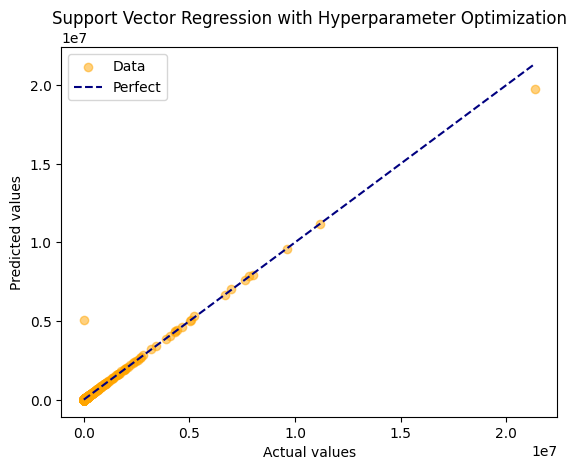

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4],  # For the polynomial kernel
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
# Train the SVR model with the best hyperparameters
best_svr = grid_search.best_estimator_
best_svr.fit(X_train, y_train)

# Make predictions
y_pred = best_svr.predict(X_test)

# Inverse the normalization of the predictions
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(1, -1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(1, -1))

y_pred_reshaped = y_pred_inv.reshape(-1)
y_test_reshaped = y_test_inv.reshape(-1)

# Evaluate the model
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Visualize the results
plt.scatter(y_test_inv, y_pred_inv, color='orange', label='Data', alpha=0.5)
plt.plot([min(y_test_reshaped), max(y_test_reshaped)], [min(y_test_reshaped), max(y_test_reshaped)], '--', color='navy', label='Perfect')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Support Vector Regression with Hyperparameter Optimization')
plt.legend()
plt.show()


<Axes: >

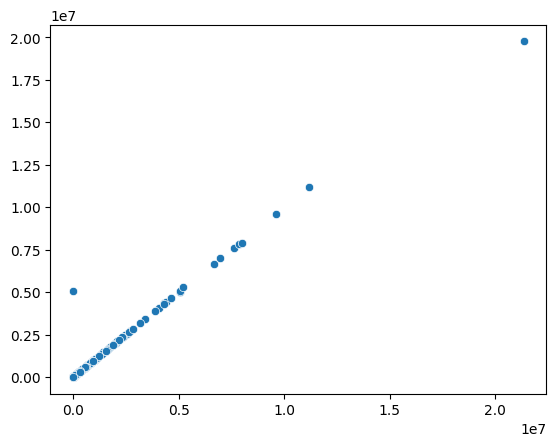

In [9]:
best_parameters = grid_search.best_params_

svm = SVR(kernel=best_parameters['kernel'],
          C=best_parameters['C'],
          gamma=best_parameters['gamma'],
          degree=best_parameters['degree'],
          epsilon=best_parameters['epsilon'])

sns.scatterplot(x=y_test_inv.reshape(-1), y=y_pred_inv.reshape(-1))


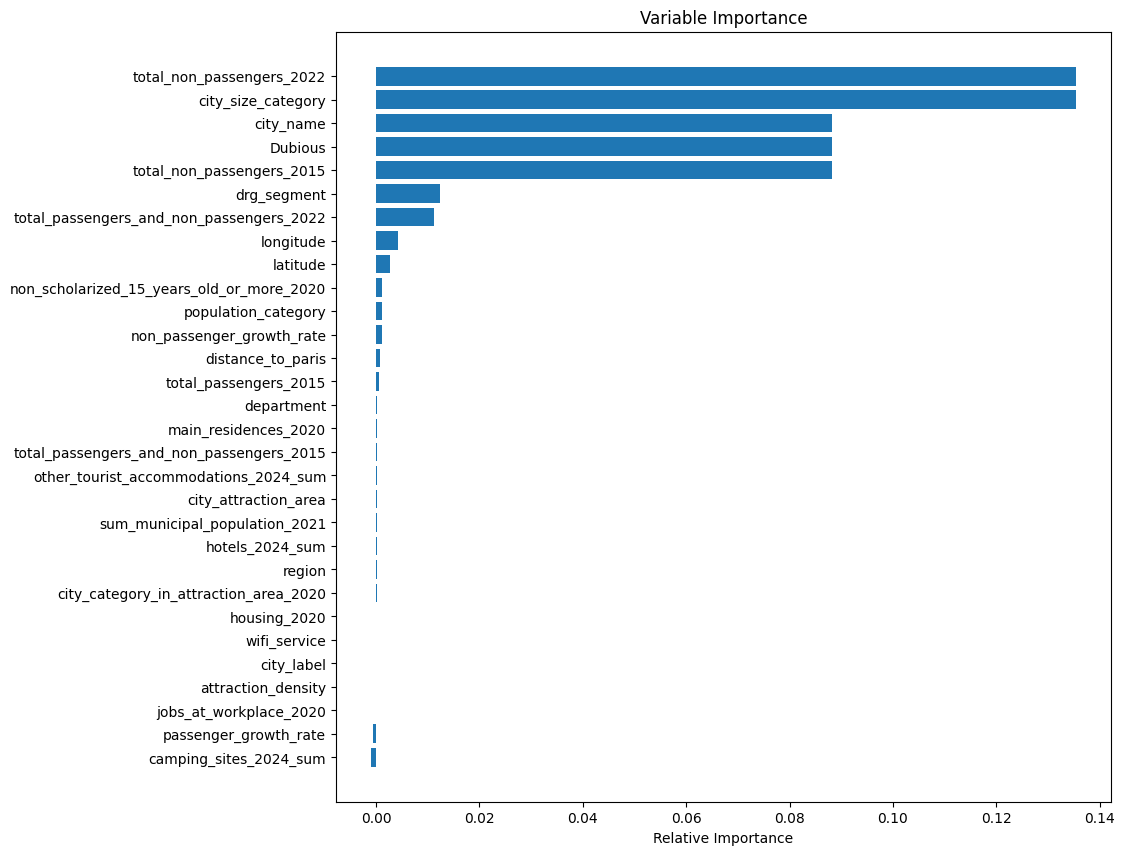

In [11]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_svr, X_test, y_test, n_repeats=30, random_state=42)
feature_importance = perm_importance.importances_mean
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()